In [1]:
%run ../src/start.py


python	3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
---------------------
Versions:
----------------------
pandas      1.1.2
numpy       1.19.1
matplotlib  3.3.1
seaborn     0.11.0
plotly      4.11.0
boto3       1.17.106
awswrangler 2.9.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
HERE_DIR: list current directory path
RAW_DIR: list files in `data\raw` directory
INTER_DIR: list files in `data\interim` directory
FINAL_DIR: list files in `data\final` directory
SRC_DIR: list files in `src\` directory
------------------------------

# SAVE PLOTS
To save a plot 

## Load Data

In [ ]:
# year file
year = ''

In [4]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [5]:
raw = bucket_raw_path('salas-data',f'capstone/inter-data/crime-data/')
raw

's3://salas-data/capstone/inter-data/crime-data/'

## List objects in bucket

In [6]:
wr.s3.list_objects(raw)

['s3://salas-data/capstone/inter-data/crime-data/crime_2009.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2010.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2011.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2012.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2013.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2014.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2015.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2016.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2017.csv',
 's3://salas-data/capstone/inter-data/crime-data/crime_2018.csv']

## Create dataframe from s3 files

In [7]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_csv(i,)
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [8]:
%%time
df = s3_files_to_df(raw)

CPU times: user 1.19 s, sys: 453 ms, total: 1.64 s
Wall time: 15.9 s


In [ ]:
## cleanup columns
#df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126360 non-null  object
 4   street_name   1126360 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126360 non-null  object
 8   premise       1126360 non-null  object
dtypes: int64(1), object(8)
memory usage: 77.3+ MB


In [10]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

date_time       0
offenses        0
offense_type    0
block_range     0
street_name     0
type            0
suffix          0
beat            0
premise         0
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date_time,0.0
offenses,0.0
offense_type,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
beat,0.0
premise,0.0


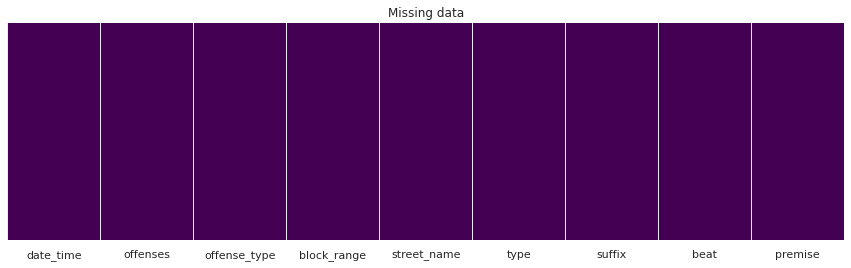

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126360 non-null  object
 4   street_name   1126360 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126360 non-null  object
 8   premise       1126360 non-null  object
dtypes: int64(1), object(8)
memory usage: 77.3+ MB


In [16]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N
